<a href="https://colab.research.google.com/github/biranchi2018/CoronaRegression/blob/master/Corona_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/
# https://www.youtube.com/watch?v=lncoLfue_Y4
# https://www.youtube.com/watch?v=arydWPLDnEc
# https://www.youtube.com/watch?v=hOLSGMEEwlI


import tensorflow as tf
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [2]:

data = np.array([38.03, 42.10, 44.04, 45.01, 47.25, 49.69, 52.19, 53.38, 56.50, 58.47, 59.32, 60.74, 
                 61.09, 62.40, 63.22, 64.36, 65.52, 66.82, 67.99, 68.91, 68.75, 69.49, 69.35, 70.05,
                 70.07, 70.58, 71.55, 73.15])

# data = np.array([38.03, 42.10, 44.04, 45.01, 47.25, 49.69, 52.19, 53.38, 56.50, 58.47, 59.32, 60.74, 
#                  61.09, 62.40, 63.22, 64.36, 65.52, 66.82, 67.99, 68.91, 68.75, 69.49, 69.35, 70.05,
#                  70.07, 70.58, 71.55, 73.15])

data

array([38.03, 42.1 , 44.04, 45.01, 47.25, 49.69, 52.19, 53.38, 56.5 ,
       58.47, 59.32, 60.74, 61.09, 62.4 , 63.22, 64.36, 65.52, 66.82,
       67.99, 68.91, 68.75, 69.49, 69.35, 70.05, 70.07, 70.58, 71.55,
       73.15])

In [3]:
len(data)

28

In [86]:
data.shape

(28,)

In [0]:
data = data.reshape(-1,1)

In [90]:
data.shape

(28, 1)

## Feature Scaling

In [91]:
data[:10]

array([[38.03],
       [42.1 ],
       [44.04],
       [45.01],
       [47.25],
       [49.69],
       [52.19],
       [53.38],
       [56.5 ],
       [58.47]])

In [0]:
sc = MinMaxScaler(feature_range = (0,1))
data = sc.fit_transform(data)

In [93]:
data[:10]

array([[0.        ],
       [0.11588838],
       [0.17112756],
       [0.19874715],
       [0.26252847],
       [0.33200456],
       [0.40318907],
       [0.43707289],
       [0.52591116],
       [0.58200456]])

## Prepare data for LSTM 

In [0]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [0]:
n_steps = 3
n_features = 1

xs, ys = split_sequence(data, n_steps)

In [149]:
xs[:10], ys[:10]

(array([[[0.        ]],
 
        [[0.11588838]],
 
        [[0.17112756]],
 
        [[0.11588838]],
 
        [[0.17112756]],
 
        [[0.19874715]],
 
        [[0.17112756]],
 
        [[0.19874715]],
 
        [[0.26252847]],
 
        [[0.19874715]]]), array([[0.19874715],
        [0.26252847],
        [0.33200456],
        [0.40318907],
        [0.43707289],
        [0.52591116],
        [0.58200456],
        [0.60620729],
        [0.64664009],
        [0.65660592]]))

In [0]:
# xs = []
# xs_range = range(0,len(ys))
# print(xs_range)
# for i in xs_range:
#   xs.append(i+1)

# xs = np.array(xs, dtype=np.float32)
# xs

In [0]:
# model = tf.keras.models.Sequential()
# model.add(tf.keras.layers.Dense(100, input_dim=1, activation='relu'))
# model.add(tf.keras.layers.Dropout(0.2))
# model.add(tf.keras.layers.Dense(100, activation='relu'))
# model.add(tf.keras.layers.Dense(10, activation='relu'))
# model.add(tf.keras.layers.Dense(1))
# model.summary()

In [99]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50, input_shape=(n_steps, n_features), activation='relu', return_sequences=True)))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.LSTM(50, activation='relu', return_sequences=True))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.LSTM(50, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(1))
# model.summary()

In [0]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_loss') < 1e-8):
      print("\nReached val_loss < 1e-8 cancelling training!")
      self.model.stop_training = True

callbacks = myCallback()

In [0]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch/20))

In [0]:
sgd_optimizer = tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9)
rmsprop_optimizer = tf.keras.optimizers.RMSprop(learning_rate=1e-6, momentum=0.9)
adam_optimizer = tf.keras.optimizers.Adam(lr=1e-8)

In [0]:
model.compile(loss='mse', optimizer=adam_optimizer, metrics=['mae'])
# model.compile(loss='mse', optimizer='sgd', metrics=['mse'])
# model.compile(loss = 'mse', optimizer='sgd' , metrics = ['mse'])

In [126]:
xs.shape

(75, 1, 1)

In [0]:
xs = xs.reshape(-1,1,1)

In [128]:
xs.shape , xs.ndim

((75, 1, 1), 3)

In [129]:
ys.shape , ys.ndim

((25, 1), 2)

In [0]:
history = model.fit(xs, ys, validation_split=0.2, epochs=2000, callbacks=[callbacks, lr_schedule], verbose=0) 

In [0]:
# xs_next = np.max(xs)+1
# xs_next = np.array([xs_next])
# xs_next

In [0]:
# xs_next = xs_next.reshape(-1,1,1)

In [0]:
# x_test = np.array([9.0])
# x_test

In [139]:
# 70.07, 70.58, 71.55, 73.15

xs_next = np.array([70.07, 70.58, 71.55])
xs_next = xs_next.reshape(-1,1)
xs_next = sc.transform(xs_next)
print(xs_next)
xs_next = xs_next.reshape((1, n_steps, n_features))

[[0.91230068]
 [0.92682232]
 [0.95444191]]


In [140]:
x_test = xs_next
print(f'x_test : {x_test}')
pred = model.predict(x_test, verbose=0)[0][0]
print(f'pred: {pred}')

x_test : [[[0.91230068]
  [0.92682232]
  [0.95444191]]]
pred: nan


In [141]:
history.history.keys()

dict_keys(['loss', 'mae', 'val_loss', 'val_mae', 'lr'])

In [142]:
type(history.history.keys())

dict_keys

In [143]:
keys = list(history.history.keys())
keys

['loss', 'mae', 'val_loss', 'val_mae', 'lr']

In [0]:
# tr_epochs = range(len(history.history['loss']))
# tr_epochs

In [0]:
# val_epochs = range(len(history.history['mse']))
# val_epochs

In [0]:
train_loss = history.history[keys[0]]
train_mse = history.history[keys[1]]
val_loss = history.history[keys[2]]
val_mse = history.history[keys[3]]

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

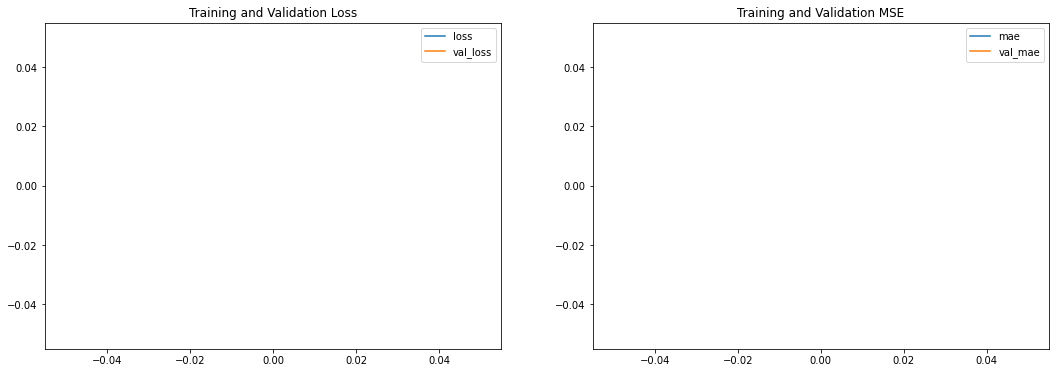

In [148]:
plt.figure(figsize=(18,6))
plt.subplot(121)
plt.plot(range(len(train_loss)), train_loss, label=keys[0])
plt.plot(range(len(val_loss)), val_loss, label=keys[2])
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.subplot(122)
plt.plot(range(len(train_mse)), train_mse, label=keys[1])
plt.plot(range(len(val_mse)), val_mse, label=keys[3])
plt.legend(loc='upper right')
plt.title('Training and Validation MSE')

plt.show()